<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [15]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import datetime
from datetime import datetime 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
import nltk
nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
#nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
#nltk.download('averaged_perceptron_tagger')
from sklearn.svm import LinearSVC
import numpy
import seaborn
import matplotlib.pyplot as plot
import math
from math import log

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanmakarov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Loads a data file from a provided file location.
def load_data(path):

    try:
        loaded_data = pd.read_csv(path)
        print(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [17]:
train_data = load_data("IA3-train.csv")

      sentiment                                               text
0             0  @united who is in charge of making decisions o...
1             0  @united great decision making skills flight op...
2             0  @AmericanAir so what if I didn't have the fund...
3             0  @united My flying United is over...sorry. The ...
4             0  @united I believe just customer service. At la...
...         ...                                                ...
8995          1  @SouthwestAir your flight attendants are reall...
8996          1  @VirginAmerica Love the team running Gate E9 a...
8997          0  @SouthwestAir really shouldn't offer sweeps if...
8998          0  @united no HUMAN contact for 2 mths from @Amer...
8999          1  @JetBlue Landing! As usual great flight wiyh a...

[9000 rows x 2 columns]


In [18]:
val_data = load_data("IA3-dev.csv")

      sentiment                                               text
0             1  @JetBlue Then en route to the airport the rebo...
1             0  @JetBlue I’m going to miss a hugely important ...
2             0  @USAirways never flying you guys again. your c...
3             0  @AmericanAir but, what I can always rely on wh...
4             0  @JetBlue you really should be more proactive w...
...         ...                                                ...
2495          0  @united kind of unnerving to watch the guy dei...
2496          0  @united already did that at the airport and 12...
2497          0  @JetBlue and they are telling me I got to get ...
2498          0  @USAirways delayed 2 days for weather and on t...
2499          0  @SouthwestAir We've been sitting at the gate f...

[2500 rows x 2 columns]


In [19]:
import numpy as np

# Loads GloVe embeddings from a designated file location. 
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find nearest neighbors via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7
    
    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    # 
    # If indicate_unk is set to True, the return type will be a tuple of 
    # (numpy array, bool) with the bool indicating whether the returned 
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)
    
    # Finds the vocab words associated with the k nearest embeddings of the provided word. 
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its 
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

In [20]:
ge = GloVe_Embedder("GloVe_Embedder_data.txt")

In [21]:
list_of_words = ['flight', 'good', 'terrible', 'help' , 'late']

In [22]:
embeds = ge.embed_list(list_of_words)

In [23]:
print(embeds)

[[-1.6572e-01 -8.3950e-02  2.2570e-02  3.9720e-02  3.0814e-01  1.7639e-01
   2.8357e-01  5.5700e-03 -9.5600e-03  1.4846e-01  4.8067e-01  2.5237e-01
  -4.3009e-01  1.6862e-01  1.2911e-01 -5.9924e-01 -1.3999e-01  4.9635e-01
  -8.2510e-02 -2.6530e-01 -2.1277e-01 -2.2453e-01  3.0011e-01 -2.8075e-01
   5.1310e-02  1.0421e+00 -6.7080e-02 -5.7052e-01  8.7370e-02 -4.3915e-01
  -8.1000e-03  5.2400e-03  2.6832e-01 -6.5057e-01 -6.3500e-02  6.0998e-01
  -7.6290e-01  1.5033e-01  9.2465e-01  1.2769e-01 -3.1095e-01  2.4462e-01
   9.2752e-01 -9.8065e-01  3.0698e-01 -9.4610e-01 -1.6245e-01 -2.9793e-01
   4.7237e-01  3.2092e-01 -2.7117e-01 -4.8036e-01  1.8380e-02 -1.4158e-01
  -3.4337e-01  1.1486e-01  2.1472e-01  7.0729e-01 -2.4157e-01 -2.1553e-01
   3.9954e-01  4.6465e-01  4.1700e-01  2.0390e-01 -3.0071e-01  1.1968e-01
   2.6760e-01  1.3740e-02  3.3544e-01 -8.0908e-01 -1.9069e-01  2.4530e-01
  -5.8880e-02 -8.7979e-01  9.5020e-01 -1.7699e-01 -2.2566e-01  1.2184e-01
   5.2940e-01  1.7246e-01  9.9000e-03 

In [24]:
word = 'flight'

In [25]:
embed = ge.embed_str(word)

In [26]:
embed

array([-1.6572e-01, -8.3950e-02,  2.2570e-02,  3.9720e-02,  3.0814e-01,
        1.7639e-01,  2.8357e-01,  5.5700e-03, -9.5600e-03,  1.4846e-01,
        4.8067e-01,  2.5237e-01, -4.3009e-01,  1.6862e-01,  1.2911e-01,
       -5.9924e-01, -1.3999e-01,  4.9635e-01, -8.2510e-02, -2.6530e-01,
       -2.1277e-01, -2.2453e-01,  3.0011e-01, -2.8075e-01,  5.1310e-02,
        1.0421e+00, -6.7080e-02, -5.7052e-01,  8.7370e-02, -4.3915e-01,
       -8.1000e-03,  5.2400e-03,  2.6832e-01, -6.5057e-01, -6.3500e-02,
        6.0998e-01, -7.6290e-01,  1.5033e-01,  9.2465e-01,  1.2769e-01,
       -3.1095e-01,  2.4462e-01,  9.2752e-01, -9.8065e-01,  3.0698e-01,
       -9.4610e-01, -1.6245e-01, -2.9793e-01,  4.7237e-01,  3.2092e-01,
       -2.7117e-01, -4.8036e-01,  1.8380e-02, -1.4158e-01, -3.4337e-01,
        1.1486e-01,  2.1472e-01,  7.0729e-01, -2.4157e-01, -2.1553e-01,
        3.9954e-01,  4.6465e-01,  4.1700e-01,  2.0390e-01, -3.0071e-01,
        1.1968e-01,  2.6760e-01,  1.3740e-02,  3.3544e-01, -8.09

In [53]:
array = []
for word in embeds:
    a = ge.find_k_nearest(word, 30)
    print(a[29][1])
    array.append(a)
print(array)    


6.20436
4.90592
5.98936
5.84511
5.65562
[[['flight', 0.0], ['plane', 4.45689], ['flights', 5.32675], ['boarding', 5.4882], ['airline', 5.58355], ['jet', 5.59065], ['flying', 5.59299], ['heading', 5.6417], ['arrival', 5.70659], ['airlines', 5.85213], ['travel', 5.89098], ['shuttle', 5.90023], ['delayed', 5.91624], ['landing', 5.92666], ['route', 5.96298], ['airplane', 6.00258], ['safe', 6.00877], ['booking', 6.01374], ['fly', 6.02409], ['departure', 6.04052], ['waiting', 6.04259], ['landed', 6.09697], ['journey', 6.12156], ['passengers', 6.12345], ['transit', 6.12451], ['delay', 6.13663], ['crew', 6.14757], ['pilot', 6.17311], ['trip', 6.18669], ['taxi', 6.20436]], [['good', 0.0], ['great', 3.64107], ['well', 3.96383], ['nice', 4.00469], ['better', 4.19665], ['night', 4.30113], ['bad', 4.34788], ['morning', 4.43596], ['way', 4.52146], ['hope', 4.54451], ['but', 4.55671], ['too', 4.57775], ['really', 4.60558], ['right', 4.68877], ['though', 4.69955], ['there', 4.70148], ['day', 4.70444],

In [100]:
array_words = []
for word in embeds:
   # print(ge.find_k_nearest(word, 30))
    re = ge.find_k_nearest(word, 30)
    array_words.append([w[1] for w in re])
print(array_words)

[[0.0, 4.45689, 5.32675, 5.4882, 5.58355, 5.59065, 5.59299, 5.6417, 5.70659, 5.85213, 5.89098, 5.90023, 5.91624, 5.92666, 5.96298, 6.00258, 6.00877, 6.01374, 6.02409, 6.04052, 6.04259, 6.09697, 6.12156, 6.12345, 6.12451, 6.13663, 6.14757, 6.17311, 6.18669, 6.20436], [0.0, 3.64107, 3.96383, 4.00469, 4.19665, 4.30113, 4.34788, 4.43596, 4.52146, 4.54451, 4.55671, 4.57775, 4.60558, 4.68877, 4.69955, 4.70148, 4.70444, 4.7177, 4.76147, 4.76949, 4.78543, 4.81795, 4.83542, 4.84457, 4.85276, 4.86179, 4.89081, 4.9018, 4.90492, 4.90592], [0.0, 2.8716, 4.31316, 5.24022, 5.35858, 5.45579, 5.49845, 5.56903, 5.58304, 5.59716, 5.631, 5.64538, 5.67322, 5.71411, 5.73043, 5.73712, 5.78009, 5.78166, 5.80851, 5.82791, 5.86491, 5.87343, 5.88777, 5.89628, 5.9003, 5.90768, 5.93984, 5.94033, 5.97906, 5.98936], [0.0, 4.66871, 4.71355, 4.8564, 5.26437, 5.27073, 5.33329, 5.35559, 5.3827, 5.39777, 5.40568, 5.42209, 5.54717, 5.55147, 5.5624, 5.58522, 5.62169, 5.6628, 5.68027, 5.74155, 5.74649, 5.75843, 5.76772, 5.7

In [101]:
from sklearn.decomposition import PCA

In [105]:
model_pca = PCA(n_components=2, svd_solver='full')

In [106]:
Xt = model_pca.fit(array_words)

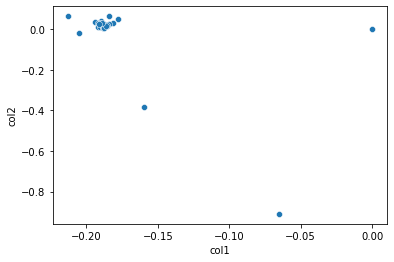

In [107]:
import seaborn as sns
category_vectors = Xt.components_.T
category_vector_frame=pd.DataFrame(category_vectors, index=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 
                                                           '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
                                                           '29', '30'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2');

In [109]:
category_vectors = Xt.components_.T
category_vectors

array([[ 3.33066907e-16,  1.11022302e-16],
       [-6.48699330e-02, -9.10128111e-01],
       [-1.59500773e-01, -3.85712208e-01],
       [-2.13063760e-01,  6.39176673e-02],
       [-2.05389937e-01, -1.77741646e-02],
       [-1.93844212e-01,  3.43536223e-02],
       [-1.89867793e-01,  4.00482166e-02],
       [-1.84020463e-01,  6.30746653e-02],
       [-1.77703902e-01,  5.08869105e-02],
       [-1.88763688e-01,  2.57380198e-02],
       [-1.92123250e-01,  3.14623432e-02],
       [-1.90631821e-01,  3.28378082e-02],
       [-1.91689197e-01,  9.66602171e-03],
       [-1.81264174e-01,  2.84676727e-02],
       [-1.83936273e-01,  2.65130949e-02],
       [-1.88180962e-01,  1.59659396e-02],
       [-1.90969384e-01,  2.53988635e-02],
       [-1.90215454e-01,  9.45755962e-03],
       [-1.85778787e-01,  1.77946422e-02],
       [-1.88275824e-01,  8.38577571e-03],
       [-1.87661926e-01,  2.58500253e-02],
       [-1.88222987e-01,  1.50589701e-02],
       [-1.88589283e-01,  1.49001209e-02],
       [-1.